# Experiments

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [2]:
% matplotlib inline

import os
import sys
import tempfile

sys.path.append("..")

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import sklearn
from sklearn import feature_selection as fs
from sklearn import preprocessing as prp
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython import display as d

from lime import lime_tabular as lt

from joblib import Memory

from libs import fourier_help

import pytff

pd.options.mode.chained_assignment = None 



## 1. Load Data

In [3]:
tile = pd.DataFrame(np.load("/home/data/carpyncho/stored/npy_tiles/cat_b278_jhk_1.npy"))

In [5]:
ogle3 = pd.read_table("../data/ogle_rr.txt", header=6)
ogle3.columns

Index([u'# ID', u'Field', u'StarID', u'RA', u'Decl', u'Type', u'I', u'V',
       u'P_1', u'dP_1', u'T0_1', u'A_1', u'R21_1', u'phi21_1', u'R31_1',
       u'phi31_1', u'P_2', u'dP_2', u'T0_2', u'A_2', u'R21_2', u'phi21_2',
       u'R31_2', u'phi31_2', u'ID_OGLE_II', u'ID_MACHO', u'ID_GCVS',
       u'ID_OTHER', u'Remarks'],
      dtype='object')

In [6]:
path = "/home/data/carpyncho/stored/samples/b278_sample.npy"
df = pd.DataFrame(np.load(path))

##  2. Preprocess

### 2.1. Discretize the classes

In [7]:
classes = set(df.ogle3_type)
sclasses_names = set(c.split("-", 1)[0] for c in classes)
classes = dict(zip(sorted(classes), range(len(classes))))
sclasses = dict(zip(sorted(sclasses_names), range(len(sclasses_names))))

df["cls"] = df.ogle3_type.apply(classes.get)
df["scls"] = df.ogle3_type.apply(lambda v: sclasses.get(v.split("-", 1)[0]))
    
d.display(d.Markdown("### Classes"))
d.display(classes)

d.display(d.Markdown("### Simplified Classes"))
d.display(sclasses)

### Classes

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

### Simplified Classes

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

,id,ra_h,dec_h,ra_j,dec_j,ra_k,dec_k,ogle3_type,ogle3_id,c89_ejk,c89_ak,n09_ejk,n09_ak
438440,32780000438441,271.349367,-30.355661,271.349367,-30.355681,271.349383,-30.355669,RRLyr-RRab,OGLE-BLG-RRLYR-12931,0.311,0.214,0.311,0.164


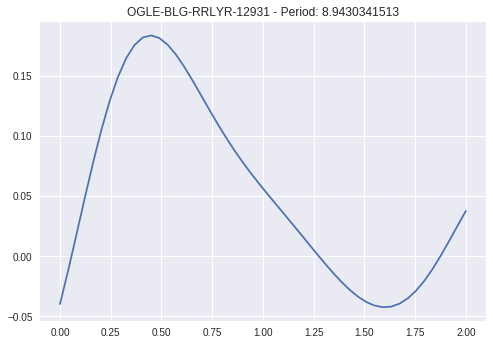

In [8]:
sample = df[df.scls == 3].sample().iloc[0]
data = fourier_help.fourier_data(sample, "FATS")
period = sample.PeriodLS
ogle3_id = tile[tile.id == sample.id].ogle3_id.values[0]
x, y = pytff.fspace(data, 0., 2, 50)
plt.title("{} - Period: {}".format(ogle3_id, period))
plt.plot(x, y);

d.display(tile[tile.id == sample.id])

url = "http://ogledb.astrouw.edu.pl/~ogle/CVS/getobj.php?starcat={}&sqlsrv=localhost&database=cvs&sqldb=all_catalog&target=all&qtype=catalog".format(ogle3_id)
# print url
# d.IFrame(url, "100%", 400)

In [11]:
def get_o3id(o3id):
    return ogle3[ogle3["# ID"] == o3id].P_1.values[0]
#     return 0
    
rr = df[df.scls == 3]
rr["ogle3_id"] = rr.id.apply(lambda cid: tile[tile.id == cid].ogle3_id.values[0])
rr["ogle3_period"] = rr.ogle3_id.apply(get_o3id)
rr["fvo3_p"] = np.abs(rr.PeriodLS - rr.ogle3_period)

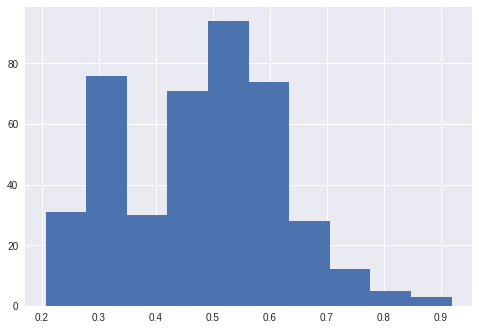

In [22]:
ax = plt.hist(rr.ogle3_period)

(-100, 500)

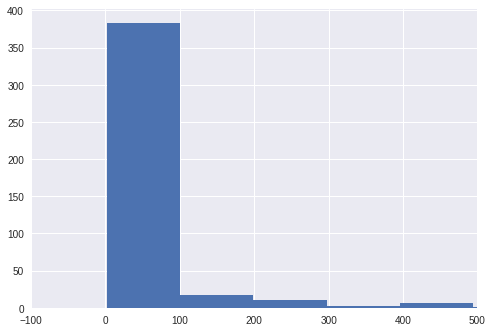

In [32]:
ax = plt.hist(rr.fvo3_p, bins=200)
plt.xlim(-100, 500)